In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import vdmlab as vdm

In [40]:
linear = dict()
linear['position'] = np.concatenate((np.linspace(0, 10, 10), np.linspace(10, 0, 10), np.linspace(0, 10, 20)))
linear['time'] = np.linspace(0, 100, 40)

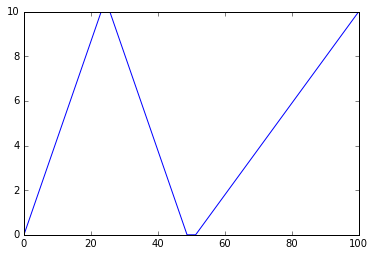

In [41]:
plt.plot(linear['time'], linear['position'])
plt.show()

In [42]:
import random
random.seed(0)
spikes = dict(time=[[], [], [], []])
for i in range(10):
    spikes['time'][0].append(random.uniform(0, 100))
for i in range(15):
    spikes['time'][1].append(random.uniform(20, 30))
for i in range(15):
    spikes['time'][2].append(random.uniform(60, 80))   
for i in range(15):
    spikes['time'][3].append(random.uniform(5, 10))
for i in range(5):
    for neuron_spikes in spikes['time']:
        neuron_spikes.append(random.uniform(0, 100))

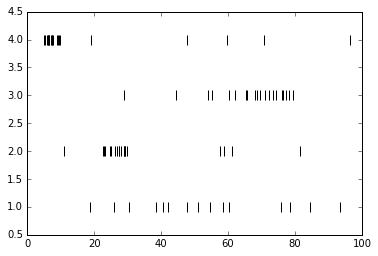

In [43]:
for idx, neuron_spikes in enumerate(spikes['time']):
    plt.plot(neuron_spikes, np.ones(len(neuron_spikes))+idx, '|', color='k', ms=10, mew=1)
plt.ylim(0.5, 4.5)
plt.show()

In [45]:
tuning = vdm.tuning_curve(linear, spikes, sampling_rate=1, binsize=3, filter_type=None)

Tuning curve with no filter.


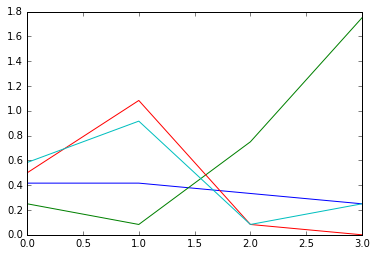

In [46]:
colours = ['b', 'g', 'r', 'c']

x = list(range(0, np.shape(tuning)[1]))
for i, neuron_tc in enumerate(tuning):
    plt.plot(neuron_tc, color=colours[i])
#     plt.fill_between(x, 0, neuron_tc, facecolor=colours[i])
plt.show()

In [47]:
tuning

[array([ 0.41666667,  0.41666667,  0.33333333,  0.25      ]),
 array([ 0.25      ,  0.08333333,  0.75      ,  1.75      ]),
 array([ 0.5       ,  1.08333333,  0.08333333,  0.        ]),
 array([ 0.58333333,  0.91666667,  0.08333333,  0.25      ])]

In [18]:
linear = dict()
linear['position'] = np.linspace(0, 9, 4)
linear['time'] = np.linspace(0, 3, 4)

In [34]:
times = [0.0, 1.0, 2.0, 2.5]
spikes = dict(time=[])
for time in times:
    spikes['time'].append([time])

In [35]:
print(linear['time'], spikes['time'])

[ 0.  1.  2.  3.] [[0.0], [1.0], [2.0], [2.5]]


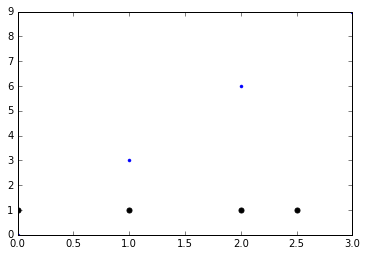

In [36]:
plt.plot(spikes['time'][0], np.ones(len(spikes['time'][0])), '.', color='k', ms=10, mew=1)
plt.plot(spikes['time'][1], np.ones(len(spikes['time'][1])), '.', color='k', ms=10, mew=1)
plt.plot(spikes['time'][2], np.ones(len(spikes['time'][2])), '.', color='k', ms=10, mew=1)
plt.plot(spikes['time'][3], np.ones(len(spikes['time'][3])), '.', color='k', ms=10, mew=1)
plt.plot(linear['time'], linear['position'], 'b.')
plt.show()

In [37]:
tuning = vdm.tuning_curve(linear, spikes, sampling_rate=1, binsize=3, filter_type=None)

Tuning curve with no filter.


In [38]:
tuning

[array([ 1.,  0.,  0.]),
 array([ 0.,  1.,  0.]),
 array([ 0. ,  0. ,  0.5]),
 array([ 0. ,  0. ,  0.5])]

In [39]:
assert np.allclose(tuning, ([1., 0., 0.], [0., 1., 0.], [0., 0., 1.]))

ValueError: operands could not be broadcast together with shapes (4,3) (3,3) 